##### Copyright 2020 The TF-Agents Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tutorial on Multi Armed Bandits in TF-Agents

### Get Started
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/bandits_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/bandits_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/bandits_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/bandits_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


### Setup

If you haven't installed the following dependencies, run:

In [2]:
!pip install tf-agents

### Imports

In [1]:
import abc
import numpy as np
import tensorflow as tf

from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step

nest = tf.nest

2022-06-09 13:29:50.018912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 13:29:50.018958: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Introduction


The Multi-Armed Bandit problem (MAB) is a special case of Reinforcement Learning: an agent collects rewards in an environment by taking some actions after observing some state of the environment. The main difference between general RL and MAB is that in MAB, we assume that the action taken by the agent does not influence the next state of the environment. Therefore, agents do not model state transitions, credit rewards to past actions, or "plan ahead" to get to reward-rich states.

As in other RL domains, the goal of a MAB *agent* is to find a *policy* that collects as much reward as possible. It would be a mistake, however, to always try to exploit the action that promises the highest reward, because then there is a chance that we miss out on better actions if we do not explore enough. This is the main problem to be solved in (MAB), often called the *exploration-exploitation dilemma*.



Bandit environments, policies, and agents for MAB can be found in subdirectories of [tf_agents/bandits](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits).

# Environments

In TF-Agents, the environment class serves the role of giving information on the current state (this is called **observation** or **context**), receiving an action as input, performing a state transition, and outputting a reward. This class also takes care of resetting when an episode ends, so that a new episode can start. This is realized by calling a `reset` function when a state is labelled as "last" of the episode.

For more details, see the [TF-Agents environments tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/2_environments_tutorial.ipynb).

As mentioned above, MAB differs from general RL in that actions do not influence the next observation. Another difference is that in Bandits, there are no "episodes": every time step starts with a new observation, independently of previous time steps.

To make sure observations are independent and to abstract away the concept of RL episodes, we introduce subclasses of `PyEnvironment` and `TFEnvironment`: [BanditPyEnvironment](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/bandit_py_environment.py) and [BanditTFEnvironment](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/bandit_tf_environment.py). These classes expose two private member functions that remain to be implemented by the user:

```python
@abc.abstractmethod
def _observe(self):
```
and
```python
@abc.abstractmethod
def _apply_action(self, action):
```
The `_observe` function returns an observation. Then, the policy chooses an action based on this observation. The `_apply_action` receives that action as an input, and returns the corresponding reward. These private member functions are called by the functions `reset` and `step`, respectively.

In [2]:
class BanditPyEnvironment(py_environment.PyEnvironment):

  def __init__(self, observation_spec, action_spec):
    self._observation_spec = observation_spec
    self._action_spec = action_spec
    super(BanditPyEnvironment, self).__init__()

  # Helper functions.
  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _empty_observation(self):
    return tf.nest.map_structure(lambda x: np.zeros(x.shape, x.dtype),
                                 self.observation_spec())

  # These two functions below should not be overridden by subclasses.
  def _reset(self):
    """Returns a time step containing an observation."""
    return ts.restart(self._observe(), batch_size=self.batch_size)

  def _step(self, action):
    """Returns a time step containing the reward for the action taken."""
    reward = self._apply_action(action)
    return ts.termination(self._observe(), reward)

  # These two functions below are to be implemented in subclasses.
  @abc.abstractmethod
  def _observe(self):
    """Returns an observation."""

  @abc.abstractmethod
  def _apply_action(self, action):
    """Applies `action` to the Environment and returns the corresponding reward.
    """

The above interim abstract class implements `PyEnvironment`'s `_reset` and `_step` functions and exposes the abstract functions `_observe` and `_apply_action` to be implemented by subclasses.

## A Simple Example Environment Class

The following class gives a very simple environment for which the observation is a random integer between -2 and 2, there are 3 possible actions (0, 1, 2), and the reward is the product of the action and the observation.

In [3]:
class SimplePyEnvironment(BanditPyEnvironment):

  def __init__(self):
    action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=-2, maximum=2, name='observation')
    super(SimplePyEnvironment, self).__init__(observation_spec, action_spec)

  def _observe(self):
    self._observation = np.random.randint(-2, 3, (1,), dtype='int32')
    return self._observation

  def _apply_action(self, action):
    return action * self._observation

Now we can use this environment to get observations, and receive rewards for our actions.

In [5]:
environment = SimplePyEnvironment()
observation = environment.reset().observation
print("observation: %d" % observation)

action = 2 #@param

print("action: %d" % action)
reward = environment.step(action).reward
print("reward: %f" % reward)

observation: 1
action: 2
reward: 2.000000


## TF Environments

One can define a bandit environment by subclassing `BanditTFEnvironment`, or, similarly to RL environments, one can define a `BanditPyEnvironment` and wrap it with `TFPyEnvironment`. For the sake of simplicity, we go with the latter option in this tutorial.

In [6]:
tf_environment = tf_py_environment.TFPyEnvironment(environment)

# Policies

A *policy* in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.

For more details, see the [TF-Agents Policy tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/3_policies_tutorial.ipynb).

As with environments, there are two ways to construct a policy: One can create a `PyPolicy` and wrap it with `TFPyPolicy`, or directly create a `TFPolicy`. Here we elect to go with the direct method.

Since this example is quite simple, we can define the optimal policy manually. The action only depends on the sign of the observation, 0 when is negative and 2 when is positive.

In [7]:
class SignPolicy(tf_policy.TFPolicy):
  def __init__(self):
    observation_spec = tensor_spec.BoundedTensorSpec(
        shape=(1,), dtype=tf.int32, minimum=-2, maximum=2)
    time_step_spec = ts.time_step_spec(observation_spec)

    action_spec = tensor_spec.BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0, maximum=2)

    super(SignPolicy, self).__init__(time_step_spec=time_step_spec,
                                     action_spec=action_spec)
  def _distribution(self, time_step):
    pass

  def _variables(self):
    return ()

  def _action(self, time_step, policy_state, seed):
    observation_sign = tf.cast(tf.sign(time_step.observation[0]), dtype=tf.int32)
    action = observation_sign + 1
    return policy_step.PolicyStep(action, policy_state)

Now we can request an observation from the environment, call the policy to choose an action, then the environment will output the reward:

In [8]:
sign_policy = SignPolicy()

current_time_step = tf_environment.reset()
print('Observation:')
print (current_time_step.observation)
action = sign_policy.action(current_time_step).action
print('Action:')
print (action)
reward = tf_environment.step(action).reward
print('Reward:')
print(reward)

Observation:
tf.Tensor([[0]], shape=(1, 1), dtype=int32)
Action:
tf.Tensor([1], shape=(1,), dtype=int32)
Reward:
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


2022-06-09 13:30:16.078425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 13:30:16.078830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ethan/miniconda3/envs/rl-fixture/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-09 13:30:16.078996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ethan/miniconda3/envs/rl-fixture/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-09 13:30:16.079134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

The way bandit environments are implemented ensures that every time we take a step, we not only receive the reward for the action we took, but also the next observation.

In [9]:
step = tf_environment.reset()
action = 1
next_step = tf_environment.step(action)
reward = next_step.reward
next_observation = next_step.observation
print("Reward: ")
print(reward)
print("Next observation:")
print(next_observation)

Reward: 
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
Next observation:
tf.Tensor([[1]], shape=(1, 1), dtype=int32)


# Agents

Now that we have bandit environments and bandit policies, it is time to also define bandit agents, that take care of changing the policy based on training samples.

The API for bandit agents does not differ from that of RL agents: the agent just needs to implement the `_initialize` and `_train` methods, and define a `policy` and a `collect_policy`.

## A More Complicated Environment

Before we write our bandit agent, we need to have an environment that is a bit harder to figure out. To spice up things just a little bit, the next environment will either always give `reward = observation * action` or `reward = -observation * action`. This will be decided when the environment is initialized.

In [10]:
class TwoWayPyEnvironment(BanditPyEnvironment):

  def __init__(self):
    action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=-2, maximum=2, name='observation')

    # Flipping the sign with probability 1/2.
    self._reward_sign = 2 * np.random.randint(2) - 1
    print("reward sign:")
    print(self._reward_sign)

    super(TwoWayPyEnvironment, self).__init__(observation_spec, action_spec)

  def _observe(self):
    self._observation = np.random.randint(-2, 3, (1,), dtype='int32')
    return self._observation

  def _apply_action(self, action):
    return self._reward_sign * action * self._observation[0]

two_way_tf_environment = tf_py_environment.TFPyEnvironment(TwoWayPyEnvironment())

reward sign:
1


## A More Complicated Policy

A more complicated environment calls for a more complicated policy. We need a policy that detects the behavior of the underlying environment. There are three situations that the policy needs to handle:

0.   The agent has not detected know yet which version of the environment is running.
1.   The agent detected that the original version of the environment is running.
2.   The agent detected that the flipped version of the environment is running.

We define a `tf_variable` named `_situation` to store this information encoded as values in `[0, 2]`, then make the policy behave accordingly.

In [11]:
class TwoWaySignPolicy(tf_policy.TFPolicy):
  def __init__(self, situation):
    observation_spec = tensor_spec.BoundedTensorSpec(
        shape=(1,), dtype=tf.int32, minimum=-2, maximum=2)
    action_spec = tensor_spec.BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0, maximum=2)
    time_step_spec = ts.time_step_spec(observation_spec)
    self._situation = situation
    super(TwoWaySignPolicy, self).__init__(time_step_spec=time_step_spec,
                                           action_spec=action_spec)
  def _distribution(self, time_step):
    pass

  def _variables(self):
    return [self._situation]

  def _action(self, time_step, policy_state, seed):
    sign = tf.cast(tf.sign(time_step.observation[0, 0]), dtype=tf.int32)
    def case_unknown_fn():
      # Choose 1 so that we get information on the sign.
      return tf.constant(1, shape=(1,))

    # Choose 0 or 2, depending on the situation and the sign of the observation.
    def case_normal_fn():
      return tf.constant(sign + 1, shape=(1,))
    def case_flipped_fn():
      return tf.constant(1 - sign, shape=(1,))

    cases = [(tf.equal(self._situation, 0), case_unknown_fn),
             (tf.equal(self._situation, 1), case_normal_fn),
             (tf.equal(self._situation, 2), case_flipped_fn)]
    action = tf.case(cases, exclusive=True)
    return policy_step.PolicyStep(action, policy_state)

## The Agent

Now it's time to define the agent that detects the sign of the environment and sets the policy appropriately.

In [12]:
class SignAgent(tf_agent.TFAgent):
  def __init__(self):
    self._situation = tf.Variable(0, dtype=tf.int32)
    policy = TwoWaySignPolicy(self._situation)
    time_step_spec = policy.time_step_spec
    action_spec = policy.action_spec
    super(SignAgent, self).__init__(time_step_spec=time_step_spec,
                                    action_spec=action_spec,
                                    policy=policy,
                                    collect_policy=policy,
                                    train_sequence_length=None)

  def _initialize(self):
    return tf.compat.v1.variables_initializer(self.variables)

  def _train(self, experience, weights=None):
    observation = experience.observation
    action = experience.action
    reward = experience.reward

    # We only need to change the value of the situation variable if it is
    # unknown (0) right now, and we can infer the situation only if the
    # observation is not 0.
    needs_action = tf.logical_and(tf.equal(self._situation, 0),
                                  tf.not_equal(reward, 0))


    def new_situation_fn():
      """This returns either 1 or 2, depending on the signs."""
      return (3 - tf.sign(tf.cast(observation[0, 0, 0], dtype=tf.int32) *
                          tf.cast(action[0, 0], dtype=tf.int32) *
                          tf.cast(reward[0, 0], dtype=tf.int32))) / 2

    new_situation = tf.cond(needs_action,
                            new_situation_fn,
                            lambda: self._situation)
    new_situation = tf.cast(new_situation, tf.int32)
    tf.compat.v1.assign(self._situation, new_situation)
    return tf_agent.LossInfo((), ())

sign_agent = SignAgent()


In the above code, the agent defines the policy, and the variable `situation` is shared by the agent and the policy.

Also, the parameter `experience` of the `_train` function is a trajectory:

# Trajectories

In TF-Agents, `trajectories` are named tuples that contain samples from previous steps taken. These samples are then used by the agent to train and update the policy. In RL, trajectories must contain information about the current state, the next state, and whether the current episode has ended. Since in the Bandit world we do not need these things, we set up a helper function to create a trajectory:

In [13]:
# We need to add another dimension here because the agent expects the
# trajectory of shape [batch_size, time, ...], but in this tutorial we assume
# that both batch size and time are 1. Hence all the expand_dims.

def trajectory_for_bandit(initial_step, action_step, final_step):
  return trajectory.Trajectory(observation=tf.expand_dims(initial_step.observation, 0),
                               action=tf.expand_dims(action_step.action, 0),
                               policy_info=action_step.info,
                               reward=tf.expand_dims(final_step.reward, 0),
                               discount=tf.expand_dims(final_step.discount, 0),
                               step_type=tf.expand_dims(initial_step.step_type, 0),
                               next_step_type=tf.expand_dims(final_step.step_type, 0))


# Training an Agent

Now all the pieces are ready for training our bandit agent.

In [14]:
step = two_way_tf_environment.reset()
for _ in range(10):
  action_step = sign_agent.collect_policy.action(step)
  next_step = two_way_tf_environment.step(action_step.action)
  experience = trajectory_for_bandit(step, action_step, next_step)
  print(experience)
  sign_agent.train(experience)
  step = next_step


Trajectory(
{'action': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>,
 'discount': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 1, 1), dtype=int32, numpy=array([[[-2]]], dtype=int32)>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-2.]], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]], dtype=int32)>})
Trajectory(
{'action': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]], dtype=int32)>,
 'discount': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 1, 1), dtype=int32, numpy=array([[[2]]], dtype=int32)>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(1, 1)

From the output one can see that after the second step (unless the observation was 0 in the first step), the policy chooses the action in the right way and thus the reward collected is always non-negative.

# A Real Contextual Bandit Example

In the rest of this tutorial, we use the pre-implemented [environments](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/) and [agents](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/) of the TF-Agents Bandits library.

In [25]:
# Imports for example.
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

import matplotlib.pyplot as plt

## Stationary Stochastic Environment with Linear Payoff Functions

The environment used in this example is the [StationaryStochasticPyEnvironment](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/stationary_stochastic_py_environment.py). This environment takes as parameter a (usually noisy) function for giving observations (context), and for every arm takes an (also noisy) function that computes the reward based on the given observation. In our example, we sample the context uniformly from a d-dimensional cube, and the reward functions are linear functions of the context, plus some Gaussian noise.

In [26]:
batch_size = 2 # @param
arm0_param = [-3, 0, 1, -2] # @param
arm1_param = [1, -2, 3, 0] # @param
arm2_param = [0, 0, 1, 1] # @param
def context_sampling_fn(batch_size):
  """Contexts from [-10, 10]^4."""
  def _context_sampling_fn():
    return np.random.randint(-10, 10, [batch_size, 4]).astype(np.float32)
  return _context_sampling_fn

class LinearNormalReward(object):
  """A class that acts as linear reward function when called."""
  def __init__(self, theta, sigma):
    self.theta = theta
    self.sigma = sigma
  def __call__(self, x):
    mu = np.dot(x, self.theta)
    return np.random.normal(mu, self.sigma)

arm0_reward_fn = LinearNormalReward(arm0_param, 1)
arm1_reward_fn = LinearNormalReward(arm1_param, 1)
arm2_reward_fn = LinearNormalReward(arm2_param, 1)

environment = tf_py_environment.TFPyEnvironment(
    sspe.StationaryStochasticPyEnvironment(
        context_sampling_fn(batch_size),
        [arm0_reward_fn, arm1_reward_fn, arm2_reward_fn],
        batch_size=batch_size))


## The LinUCB Agent

The agent below implements the [LinUCB](http://rob.schapire.net/papers/www10.pdf) algorithm.

In [27]:
observation_spec = tensor_spec.TensorSpec([4], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=2)

agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec)

## Regret Metric

Bandits' most important metric is *regret*, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a *baseline_reward_fn* function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [28]:
def compute_optimal_reward(observation):
  expected_reward_for_arms = [
      tf.linalg.matvec(observation, tf.cast(arm0_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm1_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm2_param, dtype=tf.float32))]
  optimal_action_reward = tf.reduce_max(expected_reward_for_arms, axis=0)
  return optimal_action_reward

regret_metric = tf_metrics.RegretMetric(compute_optimal_reward)

## Training

Now we put together all the components that we introduced above: the environment, the policy, and the agent. We run the policy on the environment and output training data with the help of a *driver*, and train the agent on the data.

Note that there are two parameters that together specify the number of steps taken. `num_iterations` specifies how many times we run the trainer loop, while the driver will take `steps_per_loop` steps per iteration. The main reason behind keeping both of these parameters is that some operations are done per iteration, while some are done by the driver in every step. For example, the agent's `train` function is only called once per iteration. The trade-off here is that if we train more often then our policy is "fresher", on the other hand, training in bigger batches might be more time efficient.

100%|██████████| 180/180 [00:13<00:00, 13.32it/s]


Text(0.5, 0, 'Number of Iterations')

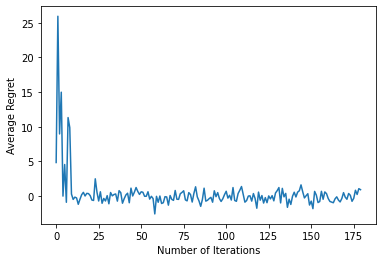

In [29]:
from tqdm import tqdm

num_iterations = 180 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in tqdm(range(num_iterations)):
  driver.run()
  loss_info = agent.train(replay_buffer.gather_all())
  replay_buffer.clear()
  regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')

After running the last code snippet, the resulting plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

In [21]:
agent.collect_policy

# What's Next?

To see more working examples, please see the [bandits/agents/examples](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples) directory that has ready-to-run examples for different agents and environments.

The TF-Agents library is also capable of handling Multi-Armed Bandits with per-arm features. To that end, we refer the reader to the per-arm bandit [tutorial](https://github.com/tensorflow/agents/tree/master/docs/tutorials/per_arm_bandits_tutorial.ipynb).